# 03: Best Model & Insights
---

## 1. Imports

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer


from sklearn.linear_model import LassoCV
from sklearn.metrics import r2_score, mean_squared_error

import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

## 2. Data

In [3]:
ames_train = pd.read_csv('../data/train_clean.csv')
ames_test = pd.read_csv('../data/test.csv')

## 3. Pre-Processing

### 3.1. Train/Validation Set Split

In [4]:
X = ames_train.drop(columns = ['pid','saleprice'])
y = ames_train['saleprice']

In [5]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 42)

### 3.2. One-Hot-Encoding, Scaling & Transforming

In [6]:
# Creating lists of the numerical and categorical features to use in the transformer

numerical = [col for col in X_train._get_numeric_data().columns]
categorical = [col for col in X_train.columns if col not in numerical]

In [7]:
# Creating a categorical feature pipeline that will one hot encode the data
cat_pipe = Pipeline([('ohe', OneHotEncoder(handle_unknown='ignore', sparse=False))])

# Creating a numerical feature pipeline that will force the different unit data into a common scale
num_pipe = Pipeline([('ss', StandardScaler())])


# Creating a ColumnTransformer that will be used to apply the pipelines to their respective features
transformer = ColumnTransformer([
    ('cat', cat_pipe, categorical),
    ('num', num_pipe, numerical)
])

In [8]:
# Applying the transformer to the X_train and converting back to a DataFrame

Xt_train = transformer.fit_transform(X_train)
Xt_train = pd.DataFrame(Xt_train, columns = transformer.get_feature_names_out(X_train.columns))

In [9]:
# Applying the transformer to the X_val and converting back to a DataFrame

Xt_val = transformer.transform(X_val)
Xt_val = pd.DataFrame(Xt_val, columns = transformer.get_feature_names_out(X_val.columns))

## 4. Best Model Insights

As discovered in the model exploration, the LassoCV model with an alpha of 79.25 is the best-performing model. Of the 301 features, 173 were eliminated, and 128 were kept. 

The evaluation metrics are as follows:

- Train R2 score: 0.9279 | Validation R2 score: 0.9262
- Train RMSE: 21,425 | Validation RMSE: 20,945

In [11]:
# Instantiating and fitting to the training data for insights

lassocv = LassoCV(alphas = np.logspace(0, 2, 100))

lassocv.fit(Xt_train, y_train)

LassoCV(alphas=array([  1.        ,   1.04761575,   1.09749877,   1.149757  ,
         1.20450354,   1.26185688,   1.32194115,   1.38488637,
         1.45082878,   1.51991108,   1.59228279,   1.66810054,
         1.7475284 ,   1.83073828,   1.91791026,   2.009233  ,
         2.10490414,   2.20513074,   2.3101297 ,   2.42012826,
         2.53536449,   2.65608778,   2.7825594 ,   2.91505306,
         3.05385551,   3.19926714,   3.35160265,   3.51119173,
         3.67837977,   3.85352859,   4.03701726,   4....
        23.64489413,  24.77076356,  25.95024211,  27.18588243,
        28.48035868,  29.8364724 ,  31.2571585 ,  32.74549163,
        34.30469286,  35.93813664,  37.64935807,  39.44206059,
        41.320124  ,  43.28761281,  45.34878508,  47.50810162,
        49.77023564,  52.14008288,  54.62277218,  57.22367659,
        59.94842503,  62.80291442,  65.79332247,  68.92612104,
        72.20809018,  75.64633276,  79.24828984,  83.02175681,
        86.97490026,  91.11627561,  95.45484567, 100.        ]))

In [12]:
# Creating a DataFrame of the features and their coefficients

lassocv_coefs = pd.DataFrame({'feature': Xt_train.columns,'coefficient': lassocv.coef_})
lassocv_coefs.sort_values(by='coefficient', ascending=False)

,feature,coefficient
38,cat__neighborhood_GrnHill,47656.553552
53,cat__neighborhood_StoneBr,41942.692476
132,cat__exter_qual_Ex,30467.682868
46,cat__neighborhood_NoRidge,27305.050919
47,cat__neighborhood_NridgHt,25024.026772
...,...,...
254,cat__misc_feature_nan,-6760.338256
35,cat__neighborhood_Edwards,-9140.458394
255,cat__sale_type_COD,-9521.082582
249,cat__misc_feature_Elev,-206577.946154


In [13]:
# Coefficients not zeroed out and greater than 0

lassocv_coefs_gr_0 = lassocv_coefs[lassocv_coefs['coefficient'] > 0]
lassocv_coefs_gr_0.sort_values(by='coefficient', ascending=False).head(10)

,feature,coefficient
38,cat__neighborhood_GrnHill,47656.553552
53,cat__neighborhood_StoneBr,41942.692476
132,cat__exter_qual_Ex,30467.682868
46,cat__neighborhood_NoRidge,27305.050919
47,cat__neighborhood_NridgHt,25024.026772
280,num__gr_liv_area,21900.914255
96,cat__roof_matl_WdShngl,21501.516792
195,cat__kitchen_qual_Ex,18961.690282
250,cat__misc_feature_Gar2,15211.589419
100,cat__exterior_1st_BrkFace,12943.136819


In [14]:
# Coefficients not zeroed out and less than 0

lassocv_coefs_ls_0 = lassocv_coefs[lassocv_coefs['coefficient'] < 0]
lassocv_coefs_ls_0.sort_values(by='coefficient', ascending=True).head(10)

,feature,coefficient
91,cat__roof_matl_ClyTile,-396409.861127
249,cat__misc_feature_Elev,-206577.946154
255,cat__sale_type_COD,-9521.082582
35,cat__neighborhood_Edwards,-9140.458394
254,cat__misc_feature_nan,-6760.338256
127,cat__mas_vnr_type_BrkCmn,-5782.143325
162,cat__bsmt_exposure_No,-5345.727687
298,num__misc_val,-4836.635158
161,cat__bsmt_exposure_Mn,-4809.754102
263,cat__sale_type_WD,-4758.461010


In [15]:
# Neighborhood feature coefficients only

lassocv_coefs_nbrh = lassocv_coefs[lassocv_coefs['feature'].str.contains('neighborhood')]
lassocv_coefs_nbrh_srt = lassocv_coefs_nbrh.sort_values(by='coefficient', ascending=False)
lassocv_coefs_nbrh_srt

,feature,coefficient
38,cat__neighborhood_GrnHill,47656.553552
53,cat__neighborhood_StoneBr,41942.692476
46,cat__neighborhood_NoRidge,27305.050919
47,cat__neighborhood_NridgHt,25024.026772
34,cat__neighborhood_Crawfor,11884.332138
52,cat__neighborhood_Somerst,10382.085529
31,cat__neighborhood_BrkSide,2410.027203
28,cat__neighborhood_Blmngtn,0.000000
29,cat__neighborhood_Blueste,0.000000
54,cat__neighborhood_Timber,0.000000


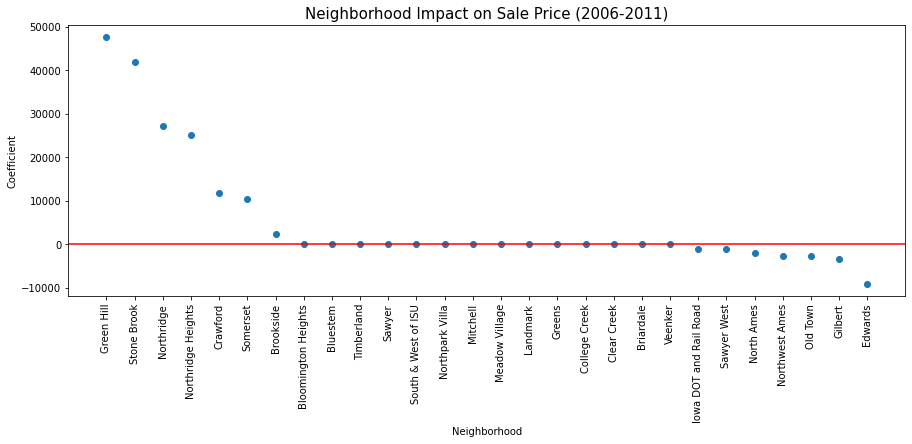

In [16]:
# Neighborhood Impact on Sale Price (2006-2011)

old_neighborhoods = ['cat__neighborhood_GrnHill',
                     'cat__neighborhood_StoneBr',
                     'cat__neighborhood_NoRidge',
                     'cat__neighborhood_NridgHt',
                     'cat__neighborhood_Crawfor',
                     'cat__neighborhood_Somerst',
                     'cat__neighborhood_BrkSide',
                     'cat__neighborhood_NPkVill',
                     'cat__neighborhood_Blmngtn', 
                     'cat__neighborhood_Blueste',
                     'cat__neighborhood_Timber',
                     'cat__neighborhood_Sawyer',
                     'cat__neighborhood_SWISU',
                     'cat__neighborhood_Veenker',
                     'cat__neighborhood_MeadowV',
                     'cat__neighborhood_Landmrk',
                     'cat__neighborhood_Greens',
                     'cat__neighborhood_CollgCr',
                     'cat__neighborhood_ClearCr',
                     'cat__neighborhood_BrDale',
                     'cat__neighborhood_Mitchel',
                     'cat__neighborhood_IDOTRR',
                     'cat__neighborhood_SawyerW',
                     'cat__neighborhood_NAmes',
                     'cat__neighborhood_OldTown',
                     'cat__neighborhood_NWAmes',
                     'cat__neighborhood_Gilbert',
                     'cat__neighborhood_Edwards']

new_neighborhoods = ['Green Hill',
                 'Stone Brook',
                 'Northridge',
                 'Northridge Heights',
                 'Crawford',
                 'Somerset',
                 'Brookside',
                 'Northpark Villa',
                 'Bloomington Heights',
                 'Bluestem',
                 'Timberland',
                 'Sawyer',
                 'South & West of ISU',
                 'Veenker',
                 'Meadow Village',
                 'Landmark',
                 'Greens',
                 'College Creek',
                 'Clear Creek',
                 'Briardale',
                 'Mitchell',
                 'Iowa DOT and Rail Road',
                 'Sawyer West',
                 'North Ames',
                 'Old Town',
                 'Northwest Ames',
                 'Gilbert',
                 'Edwards']

plt.figure(figsize=(15,5))
plt.scatter(lassocv_coefs_nbrh_srt['feature'], lassocv_coefs_nbrh_srt['coefficient'])

plt.title('Neighborhood Impact on Sale Price (2006-2011)', fontsize=15)

plt.xlabel('Neighborhood', fontsize=10)
plt.ylabel('Coefficient', fontsize=10)

plt.xticks(old_neighborhoods, new_neighborhoods, rotation=90, fontsize=10)
plt.yticks(fontsize=10)

plt.axhline(y = 0, color = 'r', linestyle = '-');

Of the 28 neighborhoods, 7 were assigned a positive coefficient, 14 were eliminated and 7 were assigned a negative coefficient.

The top 5 neighborhoods that increase home value are:

   * Green Hills by 48k
   * Stone Brook by 42k
   * Northridge by 27k
   * Northridge Heights by 25k
   * Crawford by 12k

The bottom 5 neighborhoods that decrease home value are:

   * Edwards by 9k
   * Gilbert by 3k
   * Old Town by 3k
   * Northwest Ames by 3k
   * North Ames by 2k

In [17]:
# Top 25 Home Features (excluding neighborhoods)

lassocv_coefs_no_nbrh = lassocv_coefs[~lassocv_coefs['feature'].str.contains('neighborhood')]
lassocv_coefs_no_nbrh_srt = lassocv_coefs_no_nbrh.sort_values(by='coefficient', ascending=False)
lassocv_coefs_no_nbrh_srt_top = lassocv_coefs_no_nbrh_srt.head(25)
lassocv_coefs_no_nbrh_srt_top

,feature,coefficient
132,cat__exter_qual_Ex,30467.682868
280,num__gr_liv_area,21900.914255
96,cat__roof_matl_WdShngl,21501.516792
195,cat__kitchen_qual_Ex,18961.690282
250,cat__misc_feature_Gar2,15211.589419
100,cat__exterior_1st_BrkFace,12943.136819
60,cat__condition_1_PosN,12859.430595
147,cat__bsmt_qual_Ex,12729.126431
268,num__overall_qual,11944.318216
160,cat__bsmt_exposure_Gd,11276.619178


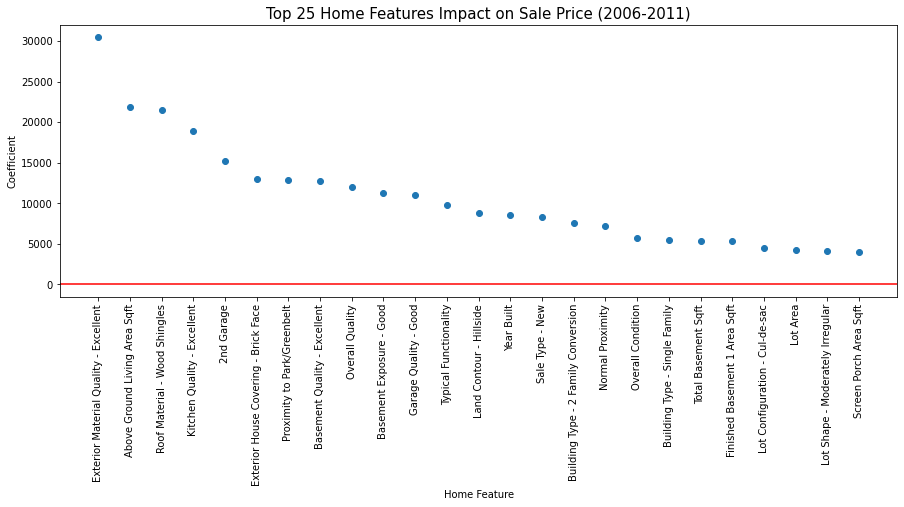

In [22]:
# Top 25 Home Features Impact on Sale Price (2006-2011)

old_features_top = ['cat__exter_qual_Ex',
                    'num__gr_liv_area',
                    'cat__roof_matl_WdShngl',
                    'cat__kitchen_qual_Ex',
                    'cat__misc_feature_Gar2',
                    'cat__exterior_1st_BrkFace',
                    'cat__condition_1_PosN',
                    'cat__bsmt_qual_Ex',
                    'num__overall_qual',
                    'cat__bsmt_exposure_Gd',
                    'cat__garage_qual_Gd',
                    'cat__functional_Typ',
                    'cat__land_contour_HLS',
                    'num__year_built',
                    'cat__sale_type_New',
                    'cat__bldg_type_2fmCon',
                    'cat__condition_1_Norm',
                    'num__overall_cond',
                    'cat__bldg_type_1Fam',
                    'num__total_bsmt_sf',
                    'num__bsmtfin_sf_1',
                    'cat__lot_config_CulDSac',
                    'num__lot_area',
                    'cat__lot_shape_IR2',
                    'num__screen_porch']

new_features_top = ['Exterior Material Quality - Excellent',
                    'Above Ground Living Area Sqft',
                    'Roof Material - Wood Shingles',
                    'Kitchen Quality - Excellent',
                    '2nd Garage',
                    'Exterior House Covering - Brick Face',
                    'Proximity to Park/Greenbelt',
                    'Basement Height - 100+ inches',
                    'Overall Quality',
                    'Basement Exposure - Good',
                    'Garage Quality - Good',
                    'Typical Functionality',
                    'Land Contour - Hillside',
                    'Year Built',
                    'Sale Type - New',
                    'Building Type - 2 Family Conversion',
                    'Normal Proximity',
                    'Overall Condition',
                    'Building Type - Single Family',
                    'Total Basement Sqft',
                    'Finished Basement 1 Area Sqft',
                    'Lot Configuration - Cul-de-sac',
                    'Lot Area',
                    'Lot Shape - Moderately Irregular',
                    'Screen Porch Area Sqft']

plt.figure(figsize=(15,5))
plt.scatter(lassocv_coefs_no_nbrh_srt_top['feature'], lassocv_coefs_no_nbrh_srt_top['coefficient'])

plt.title('Top 25 Home Features Impact on Sale Price (2006-2011)', fontsize=15)

plt.xlabel('Home Feature', fontsize=10)
plt.ylabel('Coefficient', fontsize=10);

plt.xticks(old_features_top, new_features_top, rotation=90, fontsize=10)
plt.yticks(fontsize=10)

plt.axhline(y = 0, color = 'r', linestyle = '-');

The top 5 home features that increase home value are:

   * Exterior Material Quality - Excellent by 30k
   * Above Ground Living Area Sqft by 22k
   * Roof Material - Wood Shingle by 22k
   * Kitchen Quality - Excellent by 19k
   * 2nd Garage by 15k

In [24]:
# Bottom 25 Home Features Impact on Sale Price (2006-2011)

lassocv_coefs_no_nbrh = lassocv_coefs[~lassocv_coefs['feature'].str.contains('neighborhood')]
lassocv_coefs_no_nbrh_srt = lassocv_coefs_no_nbrh.sort_values(by='coefficient', ascending=False)
lassocv_coefs_no_nbrh_srt_bottom = lassocv_coefs_no_nbrh_srt.tail(25)
lassocv_coefs_no_nbrh_srt_bottom

,feature,coefficient
61,cat__condition_1_RRAe,-2101.710179
167,cat__bsmtfin_type_1_LwQ,-2131.462881
89,cat__roof_style_Mansard,-2159.381146
286,num__kitchen_abvgr,-2257.168092
121,cat__exterior_2nd_Plywood,-2410.245975
187,cat__heating_qc_TA,-2462.151615
199,cat__functional_Maj1,-2587.365295
213,cat__garage_type_2Types,-2608.521232
103,cat__exterior_1st_HdBoard,-2683.346421
175,cat__bsmtfin_type_2_Rec,-2717.587574


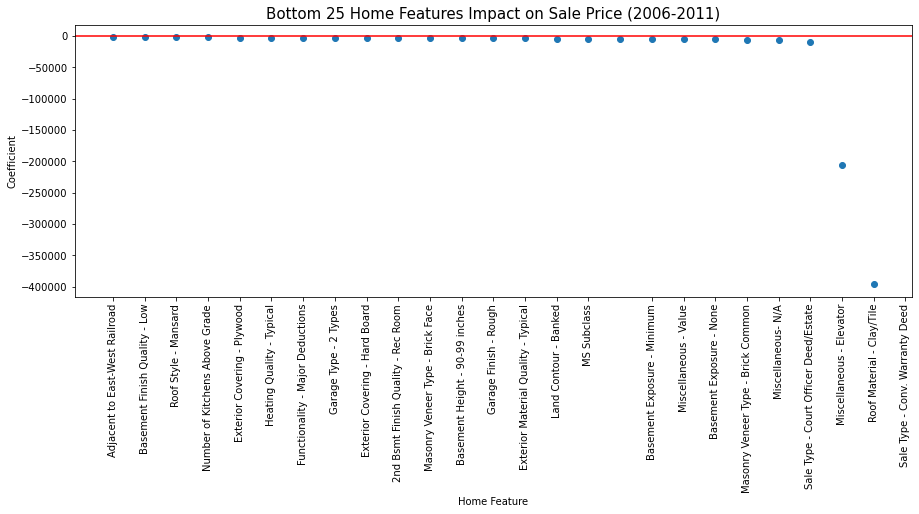

In [37]:
# Bottom 25 Home Features Impact on Sale Price (2006-2011)

old_features_bottom = ['cat__condition_1_RRAe',
                       'cat__bsmtfin_type_1_LwQ',
                       'cat__roof_style_Mansard',
                       'num__kitchen_abvgr',
                       'cat__exterior_2nd_Plywood',
                       'cat__heating_qc_TA',
                       'cat__functional_Maj1',
                       'cat__garage_type_2Types',
                       'cat__exterior_1st_HdBoard',
                       'cat__bsmtfin_type_2_Rec',
                       'cat__mas_vnr_type_BrkFace',
                       'cat__bsmt_qual_Gd',
                       'cat__garage_finish_RFn',
                       'cat__exter_qual_TA',
                       'cat__land_contour_Bnk',
                       'num__ms_subclass',
                       'cat__sale_type_WD',
                       'cat__bsmt_exposure_Mn',
                       'num__misc_val',
                       'cat__bsmt_exposure_No',
                       'cat__mas_vnr_type_BrkCmn',
                       'cat__misc_feature_nan',
                       'cat__sale_type_COD',
                       'cat__misc_feature_Elev',
                       'cat__roof_matl_ClyTile']

new_features_bottom = ['Adjacent to East-West Railroad',
                       'Basement Finish Quality - Low',
                       'Roof Style - Mansard',
                       'Number of Kitchens Above Grade',
                       'Exterior Covering - Plywood',
                       'Heating Quality - Typical',
                       'Functionality - Major Deductions',
                       'Garage Type - 2 Types',
                       'Exterior Covering - Hard Board',
                       '2nd Bsmt Finish Quality - Rec Room',
                       'Masonry Veneer Type - Brick Face',
                       'Basement Height - 90-99 inches',
                       'Garage Finish - Rough',
                       'Exterior Material Quality - Typical',
                       'Land Contour - Banked',
                       'MS Subclass',
                       'Sale Type - Conv. Warranty Deed',
                       'Basement Exposure - Minimum',
                       'Miscellaneous - Value',
                       'Basement Exposure - None',
                       'Masonry Veneer Type - Brick Common',
                       'Miscellaneous- N/A',
                       'Sale Type - Court Officer Deed/Estate',
                       'Miscellaneous - Elevator',
                       'Roof Material - Clay/Tile']

plt.figure(figsize=(15,5))
plt.scatter(lassocv_coefs_no_nbrh_srt_bottom['feature'], lassocv_coefs_no_nbrh_srt_bottom['coefficient'])

plt.title('Bottom 25 Home Features Impact on Sale Price (2006-2011)', fontsize=15)
plt.xlabel('Home Feature', fontsize=10)
plt.ylabel('Coefficient', fontsize=10)

plt.xticks(old_features_bottom, new_features_bottom, rotation=90, fontsize=10)
plt.yticks(fontsize=10)

plt.axhline(y = 0, color = 'r', linestyle = '-');

The bottom 5 home features that decrease home value are:

   * Roof Material - Clay or Tile by 396k
   * Elevator by 207k
   * Court Officer Deed/Estate Sale Type by 10k
   * Masonry Veneer Type - Brick Common by 6k
   * Basement Exposure - None by 5k